## Super Resolution

In [1]:
import fastai

from fastai.vision import *
from fastai.callbacks import *

from torchvision.models import vgg16_bn

In [2]:
from fastai import *

In [3]:
path = untar_data(URLs.PETS)

path_hr = path/'images'
path_lr = path/'small-96'
path_mr = path/'small-256'

In [4]:
il = ImageItemList.from_folder(path_hr)

In [6]:
def resize_one(fn, i):
    dest = path_lr/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, 96, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=60)

In [7]:
# parallel(resize_one, il.items) # Run only once

In [8]:
bs, size = 32, 128

arch = models.resnet34

src = ImageImageList.from_folder(path_lr).random_split_by_pct(0.1, seed=42)

In [9]:
def get_data(bs, size):
    data = (src.label_from_func(lambda x: path_hr/x.name).
               transform(get_transforms(max_zoom=2.0), size=size, tfm_y=True).
               databunch(bs=bs).normalize(imagenet_stats, do_y=True))
    data.c = 3
    return data

In [10]:
data = get_data(bs, size)

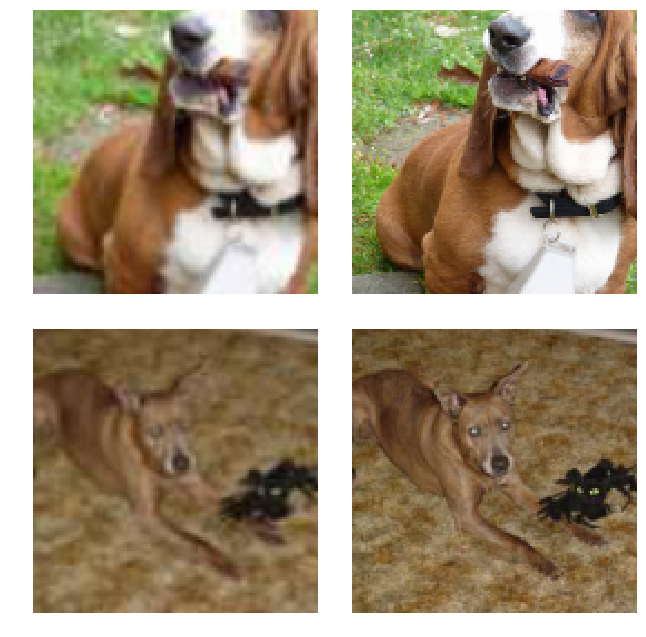

In [11]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9, 9))

### Feature Loss

In [12]:
t = data.valid_ds[0][1].data
t = torch.stack([t, t])

In [13]:
def gram_matrix(x):
    n, c, h, w = x.size()
    x = x.view(n, c, -1) # batch x channels x all_pixels
    return (x @ x.transpose(1, 2)) / (c * h * w)

In [14]:
gram_matrix(t)

tensor([[[0.1273, 0.1181, 0.0957],
         [0.1181, 0.1143, 0.0920],
         [0.0957, 0.0920, 0.0797]],

        [[0.1273, 0.1181, 0.0957],
         [0.1181, 0.1143, 0.0920],
         [0.0957, 0.0920, 0.0797]]])

In [15]:
base_loss = F.l1_loss

In [16]:
vgg_m = vgg16_bn(pretrained=True).features.cuda().eval()

In [17]:
requires_grad(vgg_m, False)

In [18]:
blocks = [i - 1 for i, o in enumerate(children(vgg_m)) if isinstance(o, nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [19]:
class FeatureLoss(nn.Module):
    """ Implements Perceptual Loss """
    def __init__(self, m_feat, layer_ids, layer_ws):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.ws = layer_ws
        
        self.metric_names = ['pixel'] + [f'feat_{i}' for i in range(len(layer_ids))] + [f'gram_{i}' for i in range(len(layer_ids))]
    
    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        
        self.feat_losses = [base_loss(input, target)]
        self.feat_losses += [base_loss(f_in, f_out) * w for f_in, f_out, w in zip(in_feat, out_feat, self.ws)]
        
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out)) * w ** 2 * 5e3
                            for f_in, f_out, w in zip(in_feat, out_feat, self.ws)]
        
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        
        return sum(self.feat_losses)
    
    def __del__(self):
        self.hooks.remove()

In [20]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5, 15, 2])

### Train

In [21]:
wd = 1e-3

learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                    blur=True, norm_type=NormType.Weight)

gc.collect()

8047

epoch     train_loss  valid_loss  pixel     feat_0    feat_1    feat_2    gram_0    gram_1    gram_2  
1         6.873608                
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


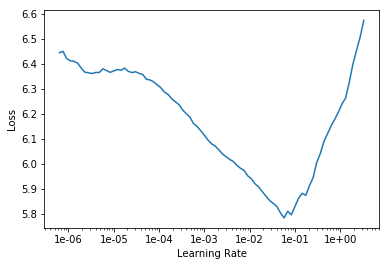

In [43]:
learn.lr_find()
learn.recorder.plot()

In [22]:
lr = 1e-3

In [23]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

epoch     train_loss  valid_loss  pixel     feat_0    feat_1    feat_2    gram_0    gram_1    gram_2  
1         5.027999    4.852611    0.731401  0.258460  0.362149  0.255515  0.705768  1.388528  1.150788  
2         4.561608    4.370269    0.602347  0.242881  0.334199  0.226491  0.652310  1.283274  1.028767  
3         4.077550    3.766376    0.359261  0.228640  0.306534  0.207777  0.541133  1.167226  0.955805  
4         3.701612    3.509885    0.195557  0.227078  0.300816  0.203122  0.508054  1.143502  0.931756  
5         3.647388    3.505773    0.179501  0.226594  0.304275  0.203222  0.511019  1.151738  0.929424  
6         3.598297    3.357094    0.164402  0.221055  0.291272  0.196870  0.486638  1.089913  0.906944  
7         3.553376    3.293066    0.146802  0.219515  0.287440  0.194288  0.473879  1.076681  0.894460  
8         3.536910    3.290201    0.141941  0.219252  0.287890  0.193918  0.474031  1.079304  0.893865  
9         3.502084    3.227321    0.140100  0.216335  0.2

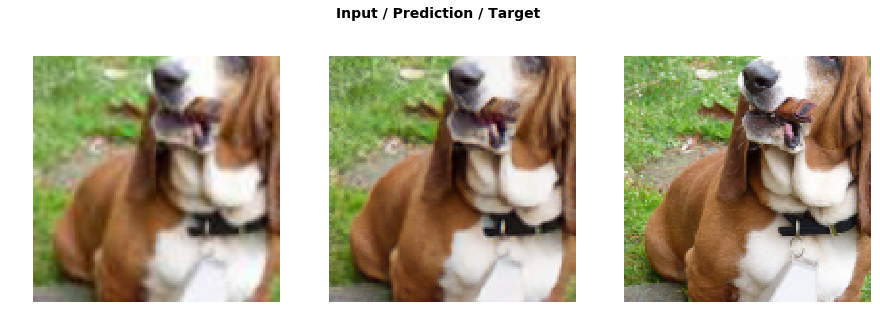

In [46]:
do_fit('1a', slice(lr * 10))

In [24]:
learn.unfreeze()

epoch     train_loss  valid_loss  pixel     feat_0    feat_1    feat_2    gram_0    gram_1    gram_2  
1         3.346709    3.104630    0.134735  0.213806  0.276593  0.183950  0.429287  1.016454  0.849804  
2         3.362329    3.091488    0.133483  0.213254  0.275873  0.183396  0.427112  1.012037  0.846332  
3         3.347953    3.086942    0.133688  0.212890  0.275380  0.182998  0.427325  1.010336  0.844326  
4         3.331592    3.085512    0.135556  0.212795  0.275035  0.182971  0.425222  1.008800  0.845132  
5         3.345385    3.085556    0.138413  0.212848  0.274930  0.182960  0.423421  1.007631  0.845353  
6         3.355066    3.097590    0.150738  0.213160  0.274810  0.182665  0.423896  1.006887  0.845435  
7         3.361491    3.079643    0.133900  0.211977  0.274447  0.182520  0.423750  1.007418  0.845631  
8         3.330469    3.068968    0.133850  0.212307  0.273458  0.182225  0.421085  1.002416  0.843628  
9         3.341545    3.062542    0.134029  0.211439  0.2

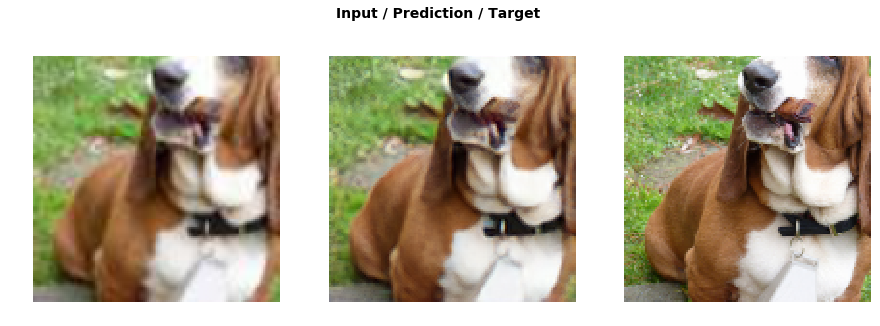

In [48]:
do_fit('1b', slice(1e-5, 1e-3))

In [26]:
## Todo

data = get_data(bs // 2, size * 2)
learn.data = data
learn.freeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,2.312043,2.161992,0.161595,0.255609,0.290164,0.151788,0.381530,0.570513,0.350793
2,2.264022,2.127149,0.164637,0.255315,0.288717,0.150405,0.363190,0.559210,0.345676
3,2.233620,2.112475,0.160090,0.255865,0.287978,0.149736,0.357249,0.558337,0.343220
4,2.229746,2.110810,0.162033,0.256554,0.287641,0.149048,0.356348,0.557884,0.341303
5,2.207470,2.077003,0.163457,0.254804,0.284482,0.147024,0.342171,0.548884,0.336181
6,2.200756,2.092173,0.183019,0.255198,0.284435,0.146791,0.339474,0.548215,0.335041
7,2.179431,2.057533,0.162248,0.253375,0.282219,0.145846,0.336454,0.543639,0.333753
8,2.169440,2.053875,0.163866,0.254738,0.281359,0.144816,0.335112,0.542750,0.331235
9,2.152279,2.050324,0.164854,0.252339,0.280100,0.144211,0.333707,0.544877,0.330236
10,2.147657,2.028785,0.163481,0.252862,0.278952,0.143354,0.328433,0.533699,0.328005


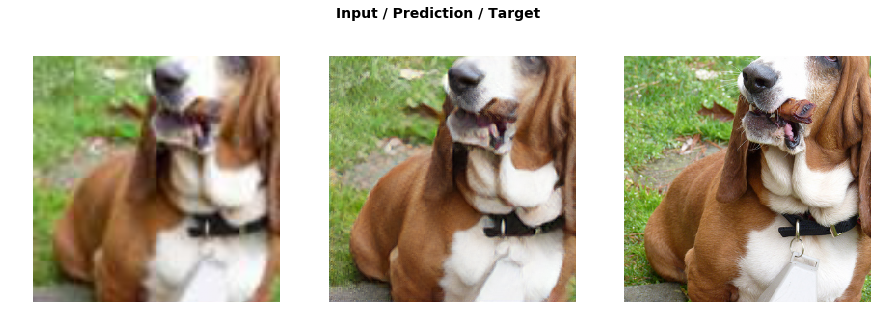

In [27]:
do_fit('2a')

### Test

In [28]:
data_mr = (ImageImageList.from_folder(path_mr).random_split_by_pct(0.1, seed=42)
          .label_from_func(lambda x: path_hr/x.name)
          .transform(get_transforms(), size=(819, 1024), tfm_y=True)
          .databunch(bs=4).normalize(imagenet_stats, do_y=True))

In [29]:
learn.data = data_mr

In [31]:
data_mr.valid_ds

LabelList
y: ImageItemList (1 items)
[]...
Path: /home/nihargajre/.fastai/data/oxford-iiit-pet/small-256
x: ImageImageList (1 items)
[]...
Path: /home/nihargajre/.fastai/data/oxford-iiit-pet/small-256